# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
# Imports

In [1]:
import csv
import pickle
import random
import PIL

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf

import os.path
import skimage.color
import sklearn.utils
import tensorflow.contrib.layers
import IPython.core.display

---

## Step 0: Load The Data

In [2]:
data_folder = './traffic-signs-data'
training_file = data_folder+'/train.p'
validation_file = data_folder+'/valid.p'
testing_file = data_folder+'/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train, sizes_train, coords_train = train['features'], train['labels'], train['sizes'], train['coords']
X_valid, y_valid, sizes_valid, coords_valid = valid['features'], valid['labels'], valid['sizes'], valid['coords']
X_test, y_test, sizes_test, coords_test = test['features'], test['labels'], test['sizes'], test['coords']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
n_train = X_train.shape[0]

n_valid = X_valid.shape[0]

n_test = X_test.shape[0]

image_shape = X_train.shape[1:]

n_classes = np.unique(np.concatenate((y_train, y_valid, y_test))).shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

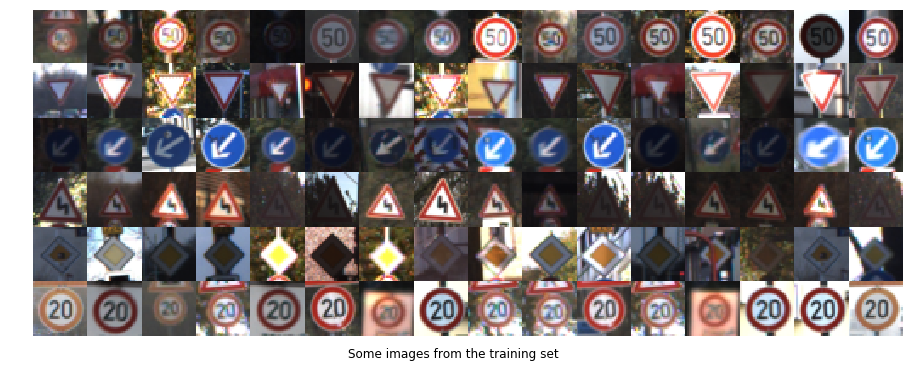

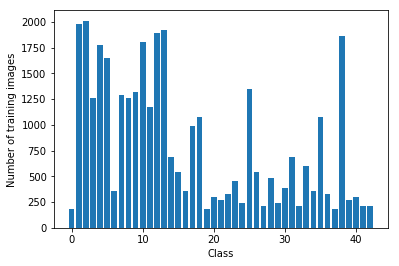

In [4]:
def assort_indices_by_class(y):
    ret =  [[] for class_ in range(n_classes)] 
    for i in range(y.shape[0]):
        ret[y[i]].append(i)
    return ret

def show_demo_grid(X, y, title):
    classes_to_show = 6
    samples_to_show = 16
    
    is_gray = (len(X.shape) == 3)
    
    height = X.shape[1]
    width = X.shape[2]
    if not is_gray:
        depth = X.shape[3]

    indices_by_class = assort_indices_by_class(y)
            
    if is_gray:
        grid_shape = (classes_to_show * height, samples_to_show * width)
    else:
        grid_shape = (classes_to_show * height, samples_to_show * width, depth)
        
    grid = np.empty(grid_shape, dtype=X.dtype)
    
    row = 0
    for c in random.sample(range(n_classes), classes_to_show):
        col = 0
        for i in random.sample(indices_by_class[c], samples_to_show):
            grid[row * height : (row+1) * height, col * width : (col+1) * width] = X[i]
            col = col + 1
        row = row + 1
    
    dpi = 32
    fig = plt.figure(0, (grid_shape[1] / dpi, grid_shape[0] / dpi))
    fig.suptitle(title, y=0.1)
    plt.axis("off")
    if is_gray:
        plt.imshow(grid, cmap='gray', vmin=-1, vmax=1)
    else:
        plt.imshow(grid)
    plt.show()

def show_samples_per_class(y):
    indices_by_class = assort_indices_by_class(y)
    plt.bar(range(n_classes), list(map(lambda i: len(indices_by_class[i]), range(n_classes))))
    plt.xlabel("Class")
    plt.ylabel("Number of training images")
    plt.show()
    
show_demo_grid(X_train, y_train, "Some images from the training set")
show_samples_per_class(y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

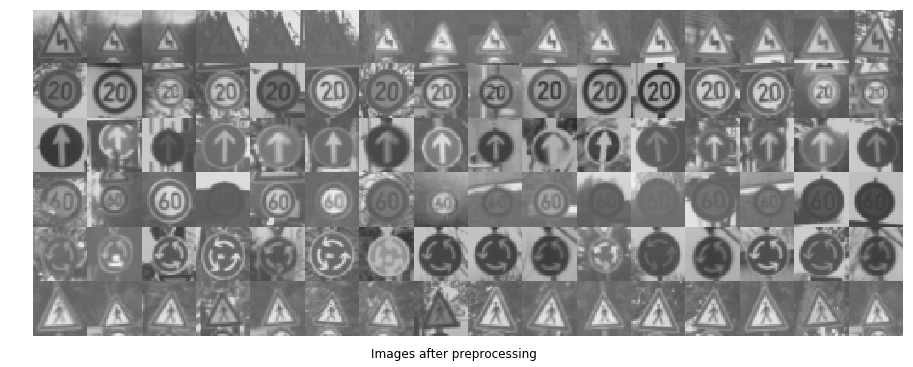

In [5]:
def normalize(img):
    min_ = np.percentile(img, 1)
    max_ = np.percentile(img, 99)
    img = np.clip(img, min_, max_)
    range_ = max_-min_
    if range_ == 0:
        range_ = 1
    img = (img-min_) / range_
    img = img - np.mean(img)
    return img

def preprocess(img):
    return normalize(skimage.color.rgb2gray(img))

def preprocess_all(images):
    res = np.empty((images.shape[0], images.shape[1], images.shape[2]), dtype=np.float32)
    for i in range(images.shape[0]):
        if i % 1000 == 0:
            print('.', end='')
        res[i] = preprocess(images[i])
    return res

force_redo_preprocess = False
prep_file_name = 'preprocessed.p'
if (not os.path.isfile(prep_file_name)) or force_redo_preprocess: 
    X_train = preprocess_all(X_train)
    X_valid = preprocess_all(X_valid)
    X_test = preprocess_all(X_test)
    pickle.dump((X_train, X_valid, X_test), open(prep_file_name, "wb"))
else:
    (X_train, X_valid, X_test) = pickle.load(open(prep_file_name, "rb"))
    
show_demo_grid(X_train, y_train, "Images after preprocessing")

## Data augmentation

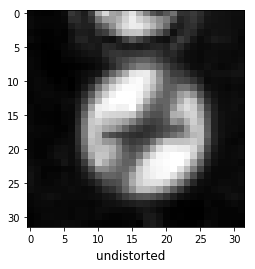

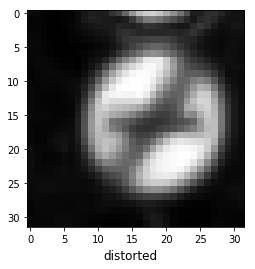

In [6]:
from skimage import transform
from skimage.transform import SimilarityTransform
from skimage.transform import warp

def distort(img):
    shift_y, shift_x = np.array(img.shape[:2]) / 2.
    
    shift = SimilarityTransform(translation=[-shift_x, -shift_y])
    tf = SimilarityTransform(
        rotation=np.deg2rad(random.uniform(-5.0, 5.0)), 
        scale=random.uniform(0.9, 1.1),
        translation=(random.uniform(-0.1, 0.1)*img.shape[0], random.uniform(-0.1, 0.1)*img.shape[1])
    )
    shift_inv = SimilarityTransform(translation=[shift_x, shift_y])
    
    return warp(img, (shift + (tf + shift_inv)).inverse, mode='edge')

def distort_all(images):
    res = np.empty_like(images)
    for i in range(images.shape[0]):
        res[i] = distort(images[i])
    return res

# Sample images to show
plt.imshow(X_train[0], cmap='gray')
plt.suptitle('undistorted', y=0.05)
plt.show()
plt.imshow(distort(X_train[0]), cmap='gray')
plt.suptitle('distorted', y=0.05)
plt.show()

force_redo_augmentation = False
aug_file_name = 'augmented.p'
if (not os.path.isfile(aug_file_name)) or force_redo_preprocess or force_redo_augmentation: 
    print("Augmenting...")
    X_train = np.concatenate((X_train, distort_all(X_train), distort_all(X_train)))
    y_train = np.concatenate((y_train, y_train, y_train))
    print("completed")
    pickle.dump((X_train, y_train), open(aug_file_name, "wb"))
else:
    (X_train, y_train) = pickle.load(open(aug_file_name, "rb"))

## Model Architecture

In [7]:
conv1_activation = None
conv2_activation = None

def MyNet(x):    
    global conv1_activation, conv2_activation
    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 32), mean = mu, stddev = sigma), name="conv1_W")
    conv1_b = tf.Variable(tf.zeros(32), name="conv1_b")
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1_activation = conv1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 28x28x32. Output = 14x14x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input = 14x14x32. Output = 10x10x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma), name="conv2_W")
    conv2_b = tf.Variable(tf.zeros(64), name="conv2_b")
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation.
    conv2_activation = conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x64. Output = 5x5x64.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 5x5x64. Output = 1600.
    fc0   = tensorflow.contrib.layers.flatten(conv2)
    fc0 = tf.nn.dropout(fc0, keep_prob)

    # Layer 3: Fully Connected. Input = 1600. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 120), mean = mu, stddev = sigma), name="fc1_W")
    fc1_b = tf.Variable(tf.zeros(120), name="fc1_b")
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation.
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma), name="fc2_W")
    fc2_b  = tf.Variable(tf.zeros(84), name="fc2_b")
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # Activation.
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma), name="fc3_W")
    fc3_b  = tf.Variable(tf.zeros(n_classes), name="fc3_b")
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [8]:
# This enables us to try the network on less train data
used_ratio = 1.0

if used_ratio < 1.0:
    used_n_train = int(used_ratio*X_train.shape[0])
    X_train, y_train = sklearn.utils.shuffle(X_train, y_train)
    X_train = X_train[0:used_n_train,:,:]
    y_train = y_train[0:used_n_train]
    
X_train = np.expand_dims(X_train, axis=3)
X_valid = np.expand_dims(X_valid, axis=3)
X_test = np.expand_dims(X_test, axis=3)

In [9]:
# Graph definition

actual_learning_rate = 0.001
actual_keep_prob = 0.7

tf.reset_default_graph() # to avoid multiple variable declarations when we run this multiple times

# input variables
keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, (None, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# output operations
logits = MyNet(x)
softmax = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = actual_learning_rate)
training_operation = optimizer.minimize(loss_operation)
prediction_operation = tf.argmax(logits, 1)
correct_prediction = tf.equal(prediction_operation, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
top5_operation = tf.nn.top_k(softmax, 5)

# Construct Saver after graph definition and before starting any sessions
saver = tf.train.Saver()

In [10]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [12]:
# Training
EPOCHS = 25
BATCH_SIZE = 128

X_train2 = np.copy(X_train)
y_train2 = np.copy(y_train)

best_valid_acc = 0
force_train = False
if (not os.path.isfile(data_folder+'/mynet.ckpt.meta')) or force_redo_preprocess or force_redo_augmentation or force_train:
    with tf.Session() as sess:
        print("Initializing...")
        sess.run(tf.global_variables_initializer()) # to start from scratch
        #saver.restore(sess, "./model/mynet.ckpt")  # to continue training
        num_examples = len(X_train)

        print("Training...")
        print()
        for i in range(EPOCHS):
            X_train2, y_train2 = sklearn.utils.shuffle(X_train2, y_train2)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train2[offset:end], y_train2[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: actual_keep_prob})

            train_accuracy = evaluate(X_train, y_train)
            validation_accuracy = evaluate(X_valid, y_valid)
            print("EPOCH {} ...".format(i+1))
            print("Train Accuracy = {:.3f}".format(train_accuracy))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            if validation_accuracy > best_valid_acc and validation_accuracy > 0.97:
                best_valid_acc = validation_accuracy
                saver.save(sess, data_folder+'/mynet.ckpt')
                print("Model saved")
            print()

Initializing...
Training...

EPOCH 1 ...
Train Accuracy = 0.921
Validation Accuracy = 0.912

EPOCH 2 ...
Train Accuracy = 0.976
Validation Accuracy = 0.960

EPOCH 3 ...
Train Accuracy = 0.985
Validation Accuracy = 0.970

EPOCH 4 ...
Train Accuracy = 0.993
Validation Accuracy = 0.974
Model saved

EPOCH 5 ...
Train Accuracy = 0.994
Validation Accuracy = 0.977
Model saved

EPOCH 6 ...
Train Accuracy = 0.995
Validation Accuracy = 0.978
Model saved

EPOCH 7 ...
Train Accuracy = 0.996
Validation Accuracy = 0.979
Model saved

EPOCH 8 ...
Train Accuracy = 0.997
Validation Accuracy = 0.982
Model saved

EPOCH 9 ...
Train Accuracy = 0.997
Validation Accuracy = 0.986
Model saved

EPOCH 10 ...
Train Accuracy = 0.999
Validation Accuracy = 0.988
Model saved

EPOCH 11 ...
Train Accuracy = 0.999
Validation Accuracy = 0.988

EPOCH 12 ...
Train Accuracy = 0.998
Validation Accuracy = 0.982

EPOCH 13 ...
Train Accuracy = 0.999
Validation Accuracy = 0.990
Model saved

EPOCH 14 ...
Train Accuracy = 0.999
Val

### Test on test set

In [14]:
with tf.Session() as sess:
    saver.restore(sess, data_folder+"/mynet.ckpt")
    
    train_accuracy = evaluate(X_train, y_train)
    print("Training Accuracy = {:.3f}".format(train_accuracy)) 
    
    valid_accuracy = evaluate(X_valid, y_valid)
    print("Validation Accuracy = {:.3f}".format(valid_accuracy)) 
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy)) 

Training Accuracy = 0.999
Validation Accuracy = 0.990
Test Accuracy = 0.967


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

See below.

### Predict the Sign Type for Each Image

See below.

### Analyze Performance

See below.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

In [15]:
class_name = [None] * n_classes
with open('signnames.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        try:
            class_name[int(row[0])] = row[1]
        except ValueError:
            pass
        
def predict(X_data):
    num_examples = len(X_data)
    predictions = []
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        prediction = sess.run(prediction_operation, feed_dict={x: batch_x, keep_prob: 1.0})
        predictions.append(prediction)
    predictions = np.concatenate(predictions)

    return predictions

def print_top5(img):
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=3)

    top5 = sess.run(top5_operation, feed_dict={x: img, keep_prob: 1.0})
    plt.bar(top5.indices[0], top5.values[0])
    plt.xlabel("Class")
    plt.ylabel('Softmax probability')
    plt.show()
    for (v,i) in zip(top5.values[0], top5.indices[0]):
        print("{0:.4f} {1}".format(v, class_name[i]))
        
def predict_name(img):
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=3)
    
    pred = predict(img)
    return class_name[pred[0]]

def load_images(names):
    images = []
    for name in names:
        images += [mpimg.imread(name)]
    return images

def resize_down(img):
    pilimg = PIL.Image.fromarray(img)
    pilimg = pilimg.resize((image_shape[1], image_shape[0]), PIL.Image.ANTIALIAS)
    return np.array(pilimg)

def process_input_image(img):
    img = resize_down(img)
    img = preprocess(img)
    return img

FileNotFoundError: [Errno 2] No such file or directory: 'signnames.csv'

Loading model...
Model loaded.


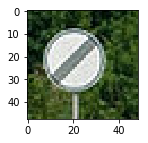

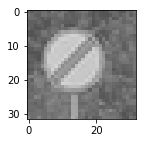

Predicted: End of all speed and passing limits (CORRECT)


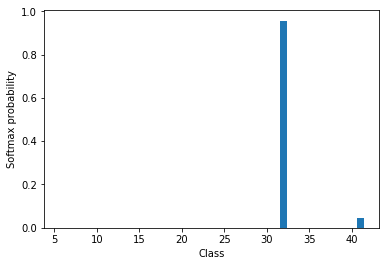

0.9561 End of all speed and passing limits
0.0437 End of no passing
0.0001 End of speed limit (80km/h)
0.0001 Keep left
0.0000 Children crossing


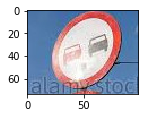

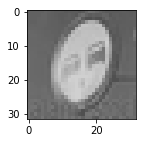

Predicted: Priority road (INCORRECT, expected: No passing)


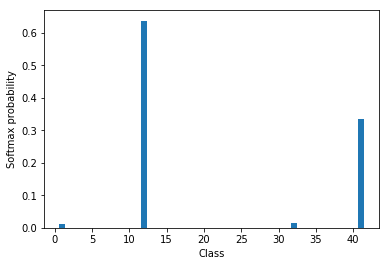

0.6373 Priority road
0.3360 End of no passing
0.0156 End of all speed and passing limits
0.0108 Speed limit (30km/h)
0.0001 Roundabout mandatory


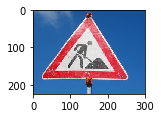

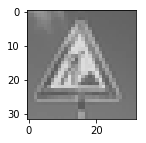

Predicted: Road work (CORRECT)


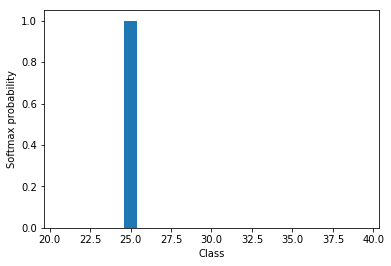

1.0000 Road work
0.0000 Bicycles crossing
0.0000 Beware of ice/snow
0.0000 Double curve
0.0000 Keep left


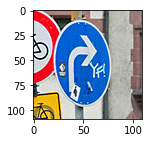

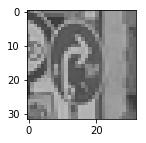

Predicted: Turn right ahead (CORRECT)


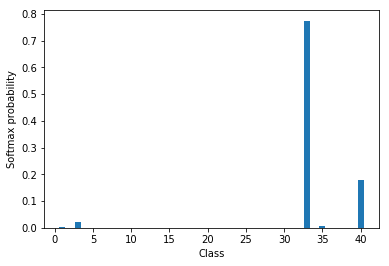

0.7743 Turn right ahead
0.1790 Roundabout mandatory
0.0226 Speed limit (60km/h)
0.0067 Ahead only
0.0042 Speed limit (30km/h)


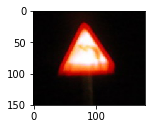

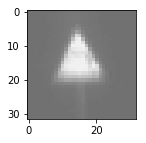

Predicted: Bumpy road (INCORRECT, expected: Dangerous curve to the left)


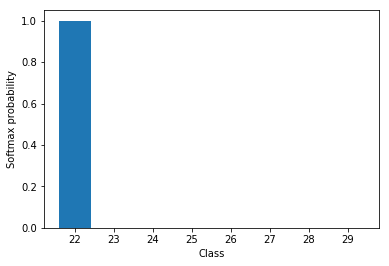

0.9999 Bumpy road
0.0000 Bicycles crossing
0.0000 Traffic signals
0.0000 Road work
0.0000 Slippery road


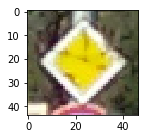

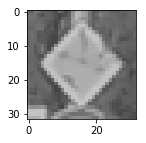

Predicted: Priority road (CORRECT)


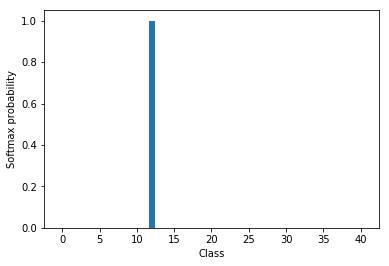

1.0000 Priority road
0.0000 Roundabout mandatory
0.0000 Keep right
0.0000 Speed limit (20km/h)
0.0000 Speed limit (30km/h)


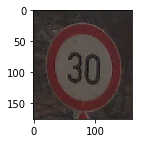

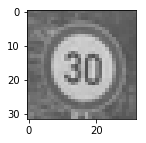

Predicted: Speed limit (30km/h) (CORRECT)


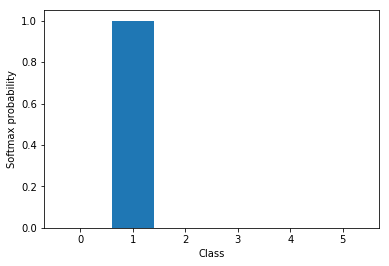

1.0000 Speed limit (30km/h)
0.0000 Speed limit (50km/h)
0.0000 Speed limit (20km/h)
0.0000 Speed limit (70km/h)
0.0000 Speed limit (80km/h)


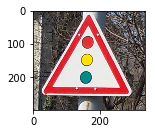

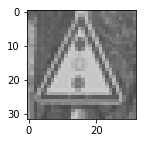

Predicted: Traffic signals (CORRECT)


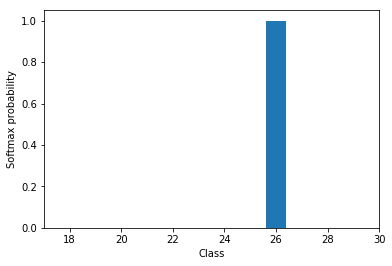

1.0000 Traffic signals
0.0000 Bumpy road
0.0000 Road work
0.0000 General caution
0.0000 Bicycles crossing



Overall precision on the new images: 75.00%


In [31]:
classes = [32, 9, 25, 33, 19, 12, 1, 26]

image_file_names = [
    './images/cut/end-of-all-speed-limits.jpg',
    './images/cut/no-passing-2.jpg',
    './images/cut/road-work.jpg',
    './images/cut/turn-right-ahead.jpg',
    './images/cut/dangerous-turn-to-the-left.jpg',
    './images/cut/my-privilaged-road.jpg',
    './images/cut/my-speed-limit-30.jpg',
    './images/cut/my-traffic-signals.jpg'
]

images = load_images(image_file_names)

print("Loading model...")
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "./model/mynet.ckpt")
    print("Model loaded.")
    
    goods = 0
    for (image, cls) in zip(images, classes):
        plt.figure(figsize=(2,2))
        plt.imshow(image)
        plt.show()
        image = process_input_image(image)
        plt.figure(figsize=(2,2))
        plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
        plt.show()
        predictedName = predict_name(image)
        if predictedName == class_name[cls]:
            print('Predicted: {0} (CORRECT)'.format(predict_name(image)))
            goods = goods + 1
        else:
            print('Predicted: {0} (INCORRECT, expected: {1})'.format(predict_name(image), class_name[cls]))
        print_top5(image)
        IPython.core.display.display(IPython.core.display.HTML("<hr />"))
    
    print()
    print("Overall precision on the new images: {:.2f}%".format(100*goods/len(images)))

---

## Step 4: Visualize the Neural Network's State with Test Images

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.


Loading model...
Model loaded.

End of no passing


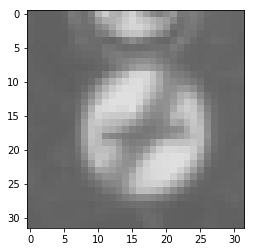

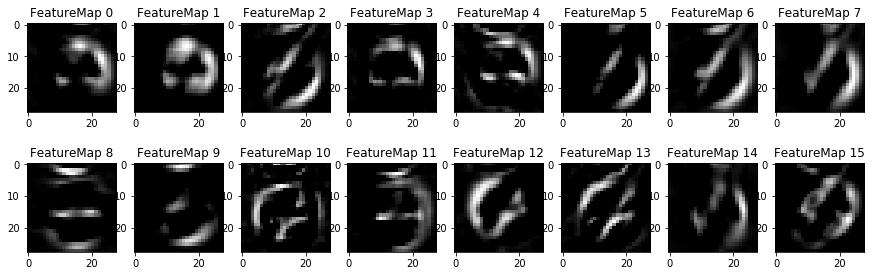

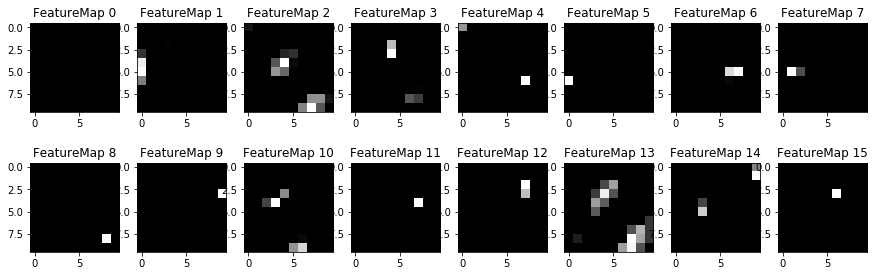

In [33]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    activation = sess.run(tf_activation, feed_dict={x: image_input, keep_prob: 1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(min([featuremaps, 16])):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
    plt.show()
            
def myOutputFeatureMap(img):
    img = np.expand_dims(img, axis=0)
    outputFeatureMap(img, conv1_activation)
    outputFeatureMap(img, conv2_activation)

print("Loading model...")
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "./model/mynet.ckpt")
    print("Model loaded.")

    print()
    print(class_name[y_train[0]])
    plt.imshow(np.squeeze(X_train[0], axis=2), cmap='gray', vmin=-1, vmax=1)
    plt.show()
    myOutputFeatureMap(X_train[0])

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


In the visualization of the activations of the first convolutional layer, I have seen that different feature maps look for different edges, for example the 7th feature map is activated by diagonal edges, and the 8th feature map is activated by horizontal edges. 

The visualization of the second convolutional layer is not easy to understand for humans.